# Assignment8

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model as LM
from feature_engine.encoding import CountFrequencyEncoder as CFE
from sklearn.model_selection import train_test_split as TTS
import statsmodels.api as sm
import numpy as np
import seaborn as sns

# How Much is Your Car Worth?

Data about the retail price of 2005 General Motors cars can be found in `car_data.csv`.

The columns are:

1. Price: suggested retail price of the used 2005 GM car in excellent condition.
2. Mileage: number of miles the car has been driven
3. Make: manufacturer of the car such as Saturn, Pontiac, and Chevrolet
4. Model: specific models for each car manufacturer such as Ion, Vibe, Cavalier
5. Trim (of car): specific type of car model such as SE Sedan 4D, Quad Coupe 2D          
6. Type: body type such as sedan, coupe, etc.      
7. Cylinder: number of cylinders in the engine        
8. Liter: a more specific measure of engine size     
9. Doors: number of doors           
10. Cruise: indicator variable representing whether the car has cruise control (1 = cruise)
11. Sound: indicator variable representing whether the car has upgraded speakers (1 = upgraded)
12. Leather: indicator variable representing whether the car has leather seats (1 = leather)

## Tasks, Part 1

1. Find the linear regression equation for mileage vs price.
2. Chart the original data and the equation on the chart.
3. Find the equation's $R^2$ score (use the `.score` method) to determine whether the
equation is a good fit for this data. (0.8 and greater is considered a strong correlation.)

## Tasks, Part 2

1. Use mileage, cylinders, liters, doors, cruise, sound, and leather to find the linear regression equation.
2. Find the equation's $R^2$ score (use the `.score` method) to determine whether the
equation is a good fit for this data. (0.8 and greater is considered a strong correlation.)
3. Find the combination of the factors that is the best predictor for price.

## Tasks, Hard Mode

1. Research dummy variables in scikit-learn to see how to use the make, model, and body type.
2. Find the best combination of factors to predict price.

In [2]:
df = pd.read_csv("car_data.csv")
df.head()

,Price,Mileage,Make,Model,Trim,Type,Cylinder,Liter,Doors,Cruise,Sound,Leather
0,17314.103129,8221,Buick,Century,Sedan 4D,Sedan,6,3.1,4,1,1,1
1,17542.036083,9135,Buick,Century,Sedan 4D,Sedan,6,3.1,4,1,1,0
2,16218.847862,13196,Buick,Century,Sedan 4D,Sedan,6,3.1,4,1,1,0
3,16336.913140,16342,Buick,Century,Sedan 4D,Sedan,6,3.1,4,1,0,0
4,16339.170324,19832,Buick,Century,Sedan 4D,Sedan,6,3.1,4,1,0,1


In [3]:
model = sm.OLS(df["Price"],sm.add_constant(df["Mileage"])).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     16.75
Date:                Fri, 24 Feb 2023   Prob (F-statistic):           4.68e-05
Time:                        22:58:05   Log-Likelihood:                -8527.8
No. Observations:                 804   AIC:                         1.706e+04
Df Residuals:                     802   BIC:                         1.707e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.476e+04    904.363     27.383      0.000     2.3e+04    2.65e+04
Mileage       -0.1725      0.042     -4.093      0.000      -0.255      -0.090
==============================================================================
Omnibus:                      236.450   Durbin-Watson:                   0.089
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              605.297
Skew:                           1.522   Prob(JB):                    3.64e-132
Kurtosis:                       5.966   Cond. No.                     5.62e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.62e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

R squared score is low.

Text(0, 0.5, 'price')

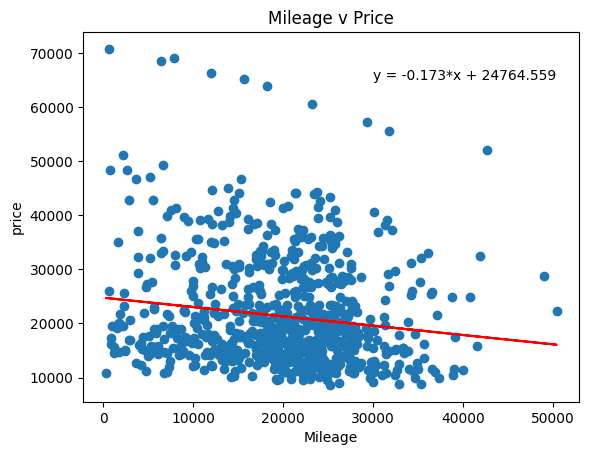

In [4]:
slope,intercept = np.polyfit(df["Mileage"],df["Price"],1)
line = df["Mileage"]*slope + intercept
plt.scatter(df["Mileage"],df["Price"])
plt.plot(df["Mileage"],line,color="red")
plt.text(30000,65000,f"y = {slope:.3f}*x + {intercept:.3f}")
plt.title("Mileage v Price")
plt.xlabel("Mileage")
plt.ylabel("price")

In [5]:

def Log(name,Predictors,ResponseV,SignificantFeatures,excludeCols,skimmed,pValues,rSq,rAdjSq):
    with open(str(name),"a") as f:
        f.write(f"""
            X:{Predictors}
            Y:{ResponseV}
            Significant Features: {SignificantFeatures}
            Removed Column: {excludeCols}
            Skimmed:{skimmed}
            pValues:{pValues}
            R^2:{rSq}
            Adj R^2:{rAdjSq}
        """)


def getPValues(x,y,pValueObj = True):
    X = sm.add_constant(x)
    lr = sm.OLS(y,X).fit()
    summary_table = np.array(lr.summary().tables[1].data)
    rSquared, rAdjSquared = [float(i[-1]) for i in lr.summary().tables[0].data[:2]]
    _,secIdx = [j for i in np.where(summary_table[:1] == "P>|t|") for j in i]
    pValue = summary_table[2:,0:secIdx+1:secIdx]
    if pValueObj == False:
        return {i[0]:i[1] for i in pValue}
    return {
        "features": [i[0] for i in pValue[0:,:1]],
        "pValues": [float(i[0]) for i in pValue[0:,1:]],
        "R^2": rSquared,
        "R^2-adj":rAdjSquared 
    }

def stepWiseRegCombined(X,y,SignificanceLevel = 0.05,thresholdToStop = 2, log = False,ResponseVNameForLog = "Not Provided",withModel = False,ReadLog = True):
    name = ""

    if log == True:
        import time as t
        name = f"Forward And Backward Regression log {t.strftime('%y_%m_%d %H_%M_%S')}.txt"

    featuresName = list(X.columns)
    SignificantFeatures = []
    excludeCols = []
    Con=True
    skimmed = {i:0 for i in featuresName}
    if featuresName.__len__() == 1:
        return {
            "model": sm.OLS(y,X).fit(),
            "oneFeatureModel": featuresName
        }
    excludeCols = featuresName[:2]
    featurePValueObj = getPValues(X[excludeCols],y)
    significantPVal = [i for i in featurePValueObj["pValues"] if i < SignificanceLevel]
    if significantPVal.__len__() != 0:
        zeroIndex = featurePValueObj["pValues"].index(0)
        significantFeature = featurePValueObj["features"][zeroIndex]
        SignificantFeatures = [*SignificantFeatures,significantFeature]
        featuresName.pop(featuresName.index(significantFeature))
        excludeColIdx = 0
        if zeroIndex == 0:
            excludeColIdx = 1
        excludeCols = [featurePValueObj["features"][excludeColIdx]]
        featuresName.pop(featuresName.index(featurePValueObj["features"][excludeColIdx]))
        featuresName = [*featuresName,featurePValueObj["features"][excludeColIdx]]
        skimmed = {
            **skimmed,
            featurePValueObj["features"][excludeColIdx]:1,
        }
        del skimmed[significantFeature]
    else:
        featureLowest = featurePValueObj["features"][featurePValueObj["pValues"].index(min(featurePValueObj["pValues"]))]
        featuresName.pop(featuresName.index(featureLowest))
        featuresName = [*featuresName,featureLowest]
        excludeCols = [featureLowest]
        skimmed = {
            **skimmed,
            featurePValueObj["features"][0]:1,
            featurePValueObj["features"][1]:1
        }
    
    if log == True:
        Log(Predictors=[X.columns[:2]],ResponseV=ResponseVNameForLog,SignificantFeatures=SignificantFeatures,excludeCols=excludeCols,name=name,skimmed=skimmed,pValues=featurePValueObj["pValues"],rAdjSq=featurePValueObj["R^2-adj"],rSq=featurePValueObj["R^2"])

    more = 0
    while Con == True and more < 100:
        more = more+1
        colsToRemove = []
        cols = [] 
        for i in featuresName:
            if i not in excludeCols:
                cols.append(i)
            else:
                colsToRemove.append(i)
        newX = X.drop(columns=colsToRemove)
        if cols.__len__() == 0:
            break
        featurePValueObj = getPValues(newX[[*SignificantFeatures,cols[0]]],y)
        if log == True:
            Log(Predictors=[*SignificantFeatures,cols[0]],ResponseV=ResponseVNameForLog,SignificantFeatures=SignificantFeatures,excludeCols=excludeCols,name=name,skimmed=skimmed,pValues=featurePValueObj["pValues"],rAdjSq=featurePValueObj["R^2-adj"],rSq=featurePValueObj["R^2"])
            
        excludeCols = []
        significantPVal = [i for i in featurePValueObj["pValues"] if i < SignificanceLevel]
        if significantPVal.__len__() != 0:
            notAll0s = []
            all0IdxFeatures = []
            for ind,i in enumerate(featurePValueObj["pValues"]):
                if i < SignificanceLevel:
                    all0IdxFeatures.append(featurePValueObj["features"][ind])
                else:
                    notAll0s.append(featurePValueObj["features"][ind])
            NotAdyInSigFeatures = [i for i in all0IdxFeatures if i not in SignificantFeatures]
            SignificantFeatures = [i for i in [*SignificantFeatures,*NotAdyInSigFeatures] if i not in notAll0s]
            for i in NotAdyInSigFeatures:
                featuresName.pop(featuresName.index(i))
                del skimmed[i]
            for i in notAll0s:
                if i in featuresName: 
                    featuresName.pop(featuresName.index(i))
                    skimmed = {
                        **skimmed,
                        i:skimmed[i] + 1,
                    }
                else:
                    skimmed = {
                        **skimmed,
                        i:1,
                    }
    
                featuresName = [*featuresName,i]
                excludeCols = [i]

        else:
            featureLowest = featurePValueObj["features"][featurePValueObj["pValues"].index(min(featurePValueObj["pValues"]))]
            featuresName.pop(featuresName.index(featureLowest))
            featuresName = [*featuresName,featureLowest]
            excludeCols = [featureLowest]
        
        if SignificantFeatures.__len__() == 0:
            for i in skimmed:
                if skimmed[i] == thresholdToStop + 2:
                    Con = True
        else:
            innerCon = False
            for i in skimmed.values():
                if i < thresholdToStop:
                    innerCon = True
            Con = innerCon
    
    if ReadLog == True and log == True:
        with open(name,"r") as f:
            print(f.read())
    
    if withModel == True:
        return {
            "SignificantFeatures":SignificantFeatures,
            "modelWithSF":sm.OLS(y,sm.add_constant(X[SignificantFeatures])).fit()
        }
    else:
        return SignificantFeatures




In [6]:
X = df[["Mileage","Doors", "Cruise", "Sound", "Leather","Cylinder", "Liter"]]
y = df["Price"]

model2 = stepWiseRegCombined(X,y,log=True,ResponseVNameForLog="Price",withModel=True,ReadLog=True,SignificanceLevel=0.01)
model2


            X:[Index(['Mileage', 'Doors'], dtype='object')]
            Y:Price
            Significant Features: ['Mileage']
            Removed Column: ['Doors']
            Skimmed:{'Doors': 1, 'Cruise': 0, 'Sound': 0, 'Leather': 0, 'Cylinder': 0, 'Liter': 0}
            pValues:[0.0, 0.0]
            R^2:0.04
            Adj R^2:0.038
        
            X:['Mileage', 'Cruise']
            Y:Price
            Significant Features: ['Mileage']
            Removed Column: ['Doors']
            Skimmed:{'Doors': 1, 'Cruise': 0, 'Sound': 0, 'Leather': 0, 'Cylinder': 0, 'Liter': 0}
            pValues:[0.0, 0.0]
            R^2:0.209
            Adj R^2:0.207
        
            X:['Mileage', 'Cruise', 'Sound']
            Y:Price
            Significant Features: ['Mileage', 'Cruise']
            Removed Column: []
            Skimmed:{'Doors': 1, 'Sound': 0, 'Leather': 0, 'Cylinder': 0, 'Liter': 0}
            pValues:[0.0, 0.0, 0.005]
            R^2:0.217
            Adj R^2:0.21

{'SignificantFeatures': ['Mileage',
  'Cruise',
  'Sound',
  'Leather',
  'Cylinder',
  'Doors'],
 'modelWithSF': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x1bfdfb318d0>}

- Each added a significance to the model, one thing to note here r^2 is 0.441. 
- The highest it reached when it is .442. Liter is highly co-related with Mileage. So model removes it as it is redundant. 
- Cylinder very well explains the variation in the price. 
- May be categorical predictor may be more info in predicted price

The best features are ``['Mileage',
  'Cruise',
  'Sound',
  'Leather',
  'Cylinder',
  'Doors']`` In design Matrix based on question 2

In [7]:
df.isnull().sum()

Price       0
Mileage     0
Make        0
Model       0
Trim        0
Type        0
Cylinder    0
Liter       0
Doors       0
Cruise      0
Sound       0
Leather     0
dtype: int64

In [8]:
con = df.corr()

Since Cylinder and Liter are highly co-related removing Liter. 

In [9]:
def plotWithGroupBy(df,columnToGroupby,yAxisCol,sortIt=False):
    if sortIt == True:
        grouped = df.groupby(by=[columnToGroupby])[yAxisCol].mean().to_frame().sort_values(ascending=0,by=[yAxisCol]).reset_index()
    else:
        grouped = df.groupby(by=[columnToGroupby])[yAxisCol].mean().to_frame().reset_index()
    
    grouped.columns = [columnToGroupby,yAxisCol]
    ax1 = sns.barplot(data=grouped,x=columnToGroupby,y=yAxisCol)
    ax1.set_xticklabels(ax1.get_xticklabels(),rotation=90)
    countDF = pd.DataFrame({"counts": [df[columnToGroupby].value_counts()[i] for i in grouped[columnToGroupby]]})
    reqDFLinePlot = pd.concat([grouped,countDF],axis=1,ignore_index=True)
    reqDFLinePlot.columns = [columnToGroupby,yAxisCol,"counts"]
    sns.lineplot(reqDFLinePlot,x=columnToGroupby,y="counts",ax=ax1.axes.twinx())
    plt.show()


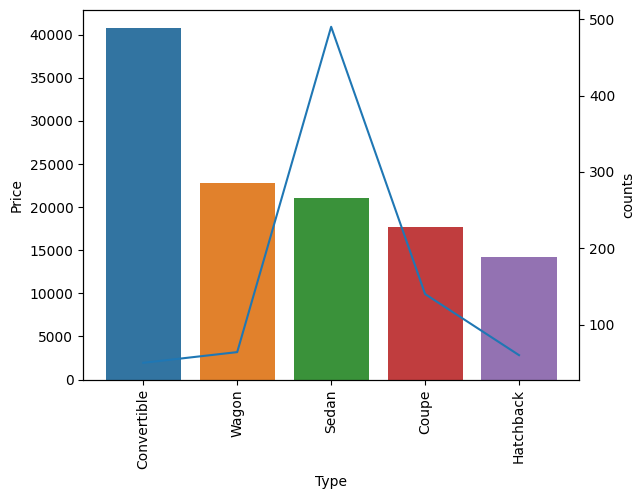

In [10]:
plotWithGroupBy(df,"Type","Price",True)

In [11]:
TypeFeature = df["Type"]
OHE_Type = pd.get_dummies(TypeFeature,prefix="Model_").drop(columns=["Model__Hatchback"])
sm.OLS(y,sm.add_constant(OHE_Type)).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.307
Model:                            OLS   Adj. R-squared:                  0.304
Method:                 Least Squares   F-statistic:                     88.51
Date:                Fri, 24 Feb 2023   Prob (F-statistic):           2.83e-62
Time:                        22:58:08   Log-Likelihood:                -8388.7
No. Observations:                 804   AIC:                         1.679e+04
Df Residuals:                     799   BIC:                         1.681e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               1.417e+04   1064.951     13.307      0.000    1.21e+04    1.63e+04
Model__Convertible  2.666e+04   1579.578     16.878      0.000    2.36e+04    2.98e+04
Model__Coupe        3556.0040   1272.860      2.794      0.005    1057.460    6054.548
Model__Sedan        6896.9997   1128.270      6.113      0.000    4682.277    9111.722
Model__Wagon        8688.3175   1482.349      5.861      0.000    5778.559    1.16e+04
==============================================================================
Omnibus:                      158.412   Durbin-Watson:                   0.131
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              264.386
Skew:                           1.246   Prob(JB):                     3.88e-58
Kurtosis:                       4.297   Cond. No.                         10.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [12]:
df = pd.concat([df,OHE_Type],axis=1)
df.drop(columns=["Liter","Type"],inplace=True)
df.head(3)

,Price,Mileage,Make,Model,Trim,Cylinder,Doors,Cruise,Sound,Leather,Model__Convertible,Model__Coupe,Model__Sedan,Model__Wagon
0,17314.103129,8221,Buick,Century,Sedan 4D,6,4,1,1,1,0,0,1,0
1,17542.036083,9135,Buick,Century,Sedan 4D,6,4,1,1,0,0,0,1,0
2,16218.847862,13196,Buick,Century,Sedan 4D,6,4,1,1,0,0,0,1,0


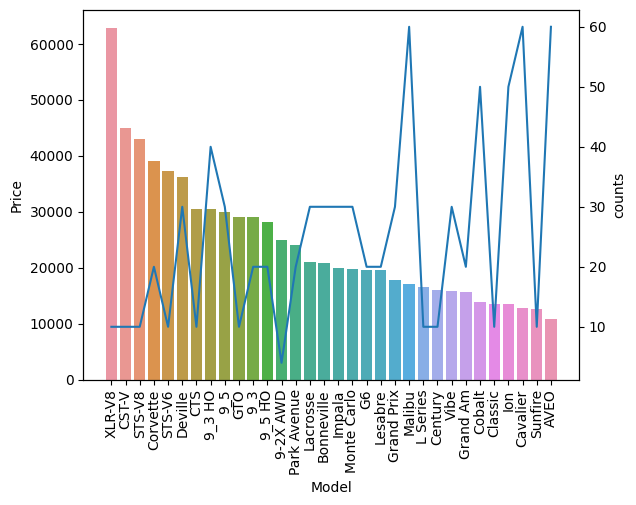

In [13]:
plotWithGroupBy(df,"Model","Price",True)

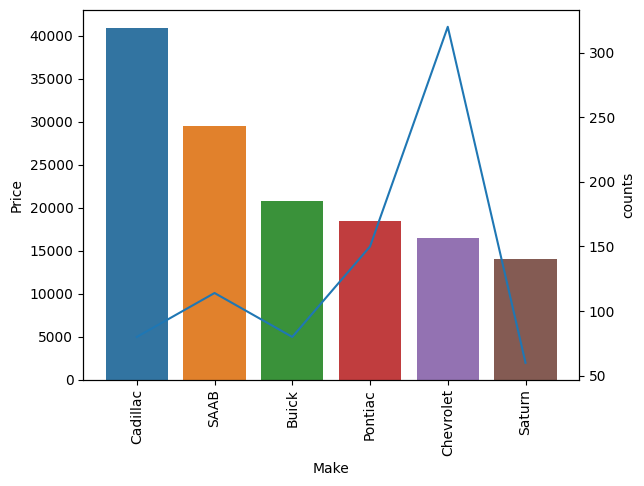

In [14]:
plotWithGroupBy(df,"Make","Price",True)

Removing Saturn to address multicollinearity among labels

In [15]:
MakeDummies = df["Make"]

MakeDF=pd.get_dummies(MakeDummies,columns=True,prefix="Make").drop("Make_Saturn",axis=1)
sm.OLS(y,sm.add_constant(MakeDF)).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.645
Model:                            OLS   Adj. R-squared:                  0.642
Method:                 Least Squares   F-statistic:                     289.6
Date:                Fri, 24 Feb 2023   Prob (F-statistic):          1.53e-176
Time:                        22:58:11   Log-Likelihood:                -8120.1
No. Observations:                 804   AIC:                         1.625e+04
Df Residuals:                     798   BIC:                         1.628e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           1.398e+04    763.050     18.320      0.000    1.25e+04    1.55e+04
Make_Buick      6836.3063   1009.420      6.773      0.000    4854.875    8817.738
Make_Cadillac   2.696e+04   1009.420     26.706      0.000     2.5e+04    2.89e+04
Make_Chevrolet  2448.7918    831.514      2.945      0.003     816.579    4081.005
Make_Pontiac    4433.2929    902.852      4.910      0.000    2661.047    6205.539
Make_SAAB       1.552e+04    942.703     16.459      0.000    1.37e+04    1.74e+04
==============================================================================
Omnibus:                      410.940   Durbin-Watson:                   0.219
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2664.441
Skew:                           2.270   Prob(JB):                         0.00
Kurtosis:                      10.676   Cond. No.                         10.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Make has r^2 greater r^2 adjusted value

In [16]:
df = pd.concat([df,MakeDF],axis=1).drop(columns=["Make"])
df.head(3)

,Price,Mileage,Model,Trim,Cylinder,Doors,Cruise,Sound,Leather,Model__Convertible,Model__Coupe,Model__Sedan,Model__Wagon,Make_Buick,Make_Cadillac,Make_Chevrolet,Make_Pontiac,Make_SAAB
0,17314.103129,8221,Century,Sedan 4D,6,4,1,1,1,0,0,1,0,1,0,0,0,0
1,17542.036083,9135,Century,Sedan 4D,6,4,1,1,0,0,0,1,0,1,0,0,0,0
2,16218.847862,13196,Century,Sedan 4D,6,4,1,1,0,0,0,1,0,1,0,0,0,0


In [17]:
TestingDf = df.drop(columns=["Model","Trim","Price"])
TestingDf

,Mileage,Cylinder,Doors,Cruise,Sound,Leather,Model__Convertible,Model__Coupe,Model__Sedan,Model__Wagon,Make_Buick,Make_Cadillac,Make_Chevrolet,Make_Pontiac,Make_SAAB
0,8221,6,4,1,1,1,0,0,1,0,1,0,0,0,0
1,9135,6,4,1,1,0,0,0,1,0,1,0,0,0,0
2,13196,6,4,1,1,0,0,0,1,0,1,0,0,0,0
3,16342,6,4,1,0,0,0,0,1,0,1,0,0,0,0
4,19832,6,4,1,0,1,0,0,1,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
799,16229,6,4,1,0,0,0,0,1,0,0,0,0,0,0
800,19095,6,4,1,1,0,0,0,1,0,0,0,0,0,0
801,20484,6,4,1,1,0,0,0,1,0,0,0,0,0,0
802,25979,6,4,1,1,0,0,0,1,0,0,0,0,0,0


In [18]:
xt,xT,yt,yT = TTS(TestingDf,y,test_size=0.3)

In [42]:
sm.OLS(yt,sm.add_constant(xt)).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.917
Model:                            OLS   Adj. R-squared:                  0.914
Method:                 Least Squares   F-statistic:                     429.0
Date:                Fri, 24 Feb 2023   Prob (F-statistic):          4.04e-284
Time:                        23:22:26   Log-Likelihood:                -5281.8
No. Observations:                 562   AIC:                         1.059e+04
Df Residuals:                     547   BIC:                         1.066e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               5096.3260    393.599     12.948      0.000    4323.176    5869.476
Mileage               -0.2013      0.016    -12.761      0.000      -0.232      -0.170
Cylinder            3850.4058    135.269     28.465      0.000    3584.695    4116.116
Doors              -1862.2465    221.530     -8.406      0.000   -2297.400   -1427.093
Cruise               215.7473    366.235      0.589      0.556    -503.652     935.146
Sound                613.5507    285.609      2.148      0.032      52.526    1174.576
Leather              919.1711    307.992      2.984      0.003     314.179    1524.163
Model__Convertible  1.098e+04    593.607     18.496      0.000    9813.613    1.21e+04
Model__Coupe         144.1339    416.338      0.346      0.729    -673.683     961.951
Model__Sedan        2267.7650    560.832      4.044      0.000    1166.117    3369.413
Model__Wagon        6817.6825    755.022      9.030      0.000    5334.585    8300.780
Make_Buick           810.0537    690.774      1.173      0.241    -546.841    2166.948
Make_Cadillac       1.292e+04    769.771     16.783      0.000    1.14e+04    1.44e+04
Make_Chevrolet      -510.6552    550.727     -0.927      0.354   -1592.454     571.143
Make_Pontiac       -1282.8782    612.949     -2.093      0.037   -2486.899     -78.857
Make_SAAB           1.257e+04    686.877     18.299      0.000    1.12e+04    1.39e+04
==============================================================================
Omnibus:                       42.135   Durbin-Watson:                   1.952
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              107.000
Skew:                           0.374   Prob(JB):                     5.82e-24
Kurtosis:                       5.003   Cond. No.                     1.43e+19
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.22e-27. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [28]:
FullModel1 = stepWiseRegCombined(xt,yt,log=True,ReadLog=True,ResponseVNameForLog="Price",withModel=True,SignificanceLevel=0.05)


            X:[Index(['Mileage', 'Cylinder'], dtype='object')]
            Y:Price
            Significant Features: ['Mileage']
            Removed Column: ['Cylinder']
            Skimmed:{'Cylinder': 1, 'Doors': 0, 'Cruise': 0, 'Sound': 0, 'Leather': 0, 'Model__Convertible': 0, 'Model__Coupe': 0, 'Model__Sedan': 0, 'Model__Wagon': 0, 'Make_Buick': 0, 'Make_Cadillac': 0, 'Make_Chevrolet': 0, 'Make_Pontiac': 0, 'Make_SAAB': 0}
            pValues:[0.0, 0.0]
            R^2:0.35
            Adj R^2:0.348
        
            X:['Mileage', 'Doors']
            Y:Price
            Significant Features: ['Mileage']
            Removed Column: ['Cylinder']
            Skimmed:{'Cylinder': 1, 'Doors': 0, 'Cruise': 0, 'Sound': 0, 'Leather': 0, 'Model__Convertible': 0, 'Model__Coupe': 0, 'Model__Sedan': 0, 'Model__Wagon': 0, 'Make_Buick': 0, 'Make_Cadillac': 0, 'Make_Chevrolet': 0, 'Make_Pontiac': 0, 'Make_SAAB': 0}
            pValues:[0.0, 0.0]
            R^2:0.051
            Adj R^2:0.0

In [29]:
FullModel1["modelWithSF"].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.916
Model:                            OLS   Adj. R-squared:                  0.915
Method:                 Least Squares   F-statistic:                     501.3
Date:                Fri, 24 Feb 2023   Prob (F-statistic):          1.40e-286
Time:                        23:12:34   Log-Likelihood:                -5282.4
No. Observations:                 562   AIC:                         1.059e+04
Df Residuals:                     549   BIC:                         1.065e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               5313.6124   1103.419      4.816      0.000    3146.172    7481.052
Mileage               -0.2007      0.016    -12.748      0.000      -0.232      -0.170
Leather              857.9041    302.212      2.839      0.005     264.270    1451.538
Model__Convertible  1.078e+04    655.127     16.455      0.000    9493.006    1.21e+04
Model__Wagon        6901.8311    749.110      9.213      0.000    5430.359    8373.303
Make_Cadillac       1.342e+04    567.949     23.624      0.000    1.23e+04    1.45e+04
Make_SAAB            1.31e+04    465.192     28.161      0.000    1.22e+04     1.4e+04
Cylinder            3858.9389    126.090     30.605      0.000    3611.260    4106.618
Doors              -2017.3321    283.742     -7.110      0.000   -2574.685   -1459.979
Model__Sedan        2403.8309    541.875      4.436      0.000    1339.429    3468.232
Sound                567.1713    279.068      2.032      0.043      19.000    1115.342
Make_Pontiac        -844.3628    401.148     -2.105      0.036   -1632.335     -56.391
Make_Buick          1287.5918    498.549      2.583      0.010     308.295    2266.888
==============================================================================
Omnibus:                       41.894   Durbin-Watson:                   1.950
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              106.386
Skew:                           0.371   Prob(JB):                     7.92e-24
Kurtosis:                       4.998   Cond. No.                     2.03e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.03e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""